### CellAssign
https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/cellassign_tutorial.html#create-and-fit-cellassign-model

In [1]:
import scanpy as sc
import anndata as ad
import scvi
import seaborn as sns
import torch
import pandas as pd
from scvi.external import CellAssign
import numpy as np

In [2]:
import os
os.chdir("/dcs04/lieber/lcolladotor/spatialHPC_LIBD4035/spatial_hpc")
os.getcwd()

'/dcs04/lieber/lcolladotor/spatialHPC_LIBD4035/spatial_hpc'

In [3]:
#adata_annot = ad.read_h5ad("snRNAseq_hpc/python_analysis/processed-data/adata_qc-strict.h5")
adata_filt = ad.read_h5ad("snRNAseq_hpc/python_analysis/processed-data/adata_qc-strict_scvi-2k-hdg_processed.h5")
adata_filt.shape #74216

(74216, 30790)

In [4]:
adata_filt = adata_filt[adata_filt.obs['prelim_celltypes']=="none"]
adata_filt.shape #35066

(35066, 30790)

The initial run used markers from human HPC (one of the references from the manuscript). <br>
Erik will be compiling a list of cell type markers in the next week that will replace the list used in this example.

In [15]:
#celltype_markers = pd.read_csv("snRNAseq_hpc/python_analysis/processed-data/Ayhan_2021_TableS2_binary.csv", index_col=0)
hpc_markers = pd.read_csv("snRNAseq_hpc/python_analysis/processed-data/Cembrowski_2016_TableS1_binary.csv", index_col=16)
hpc_markers = hpc_markers[['dg_d','dg_v','ca4','ca3_d','ca3_v','ca2','ca1_d','ca1_v']]

In [6]:
key = hpc_markers.index[hpc_markers.index.isin(adata_filt.var_names)]
#hpc_markers = hpc_markers.loc[key].index
adata_filt = adata_filt[:,key].copy()
adata_filt.shape #208 genes

(35066, 208)

In [7]:
lib_size = adata_filt.X.sum(1)
adata_filt.obs["size_factor"] = lib_size / np.mean(lib_size)

In [8]:
adata_filt.X = adata_filt.layers["counts"].copy()

In [9]:
scvi.external.CellAssign.setup_anndata(adata_filt, size_factor_key="size_factor")

In [11]:
hpc_markers

Index(['ABLIM3', 'AKAP7', 'ARHGAP20', 'BTG2', 'C1QL2', 'CALD1', 'CYGB', 'DGKH',
       'DOCK10', 'FAM163B',
       ...
       'ZDHHC2', 'ADRA1A', 'AGRP', 'DCN', 'GRIN3A', 'LDB2', 'NDRG1', 'NDST3',
       'SERPINE2', 'TOX'],
      dtype='object', name='gene_name', length=208)

In [17]:
annot_model = CellAssign(adata_filt, hpc_markers)
annot_model.train(early_stopping=True, early_stopping_patience=25)
#early stopping defaults to patience of 45 (my first trial showed that the model continued well after the elbow plot flattened out
#based on the elbow plot from the tutorial that should be good to cutoff well before 400
#https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.html#scvi.model.SCVI.train
#https://docs.scvi-tools.org/en/stable/api/reference/scvi.train.Trainer.html#scvi.train.Trainer

/users/jthompso/.conda/envs/snPy/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/jthompso/.conda/envs/snPy/lib/python3.10/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/users/jthompso/.conda/envs/snPy/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/jthompso/.conda/envs/snPy/lib/python3.10/site ...


Epoch 400/400: 100%|██████████████████████████████████████████████| 400/400 [2:29:55<00:00, 24.67s/it, v_num=1, train_loss_step=308, train_loss_epoch=311]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████████████████████| 400/400 [2:29:55<00:00, 22.49s/it, v_num=1, train_loss_step=308, train_loss_epoch=311]


In [18]:
annot_model.save("snRNAseq_hpc/python_analysis/processed-data/scvi-CellAssign_model_strict-processed-Cembrowski", overwrite=True)

<Axes: xlabel='epoch'>

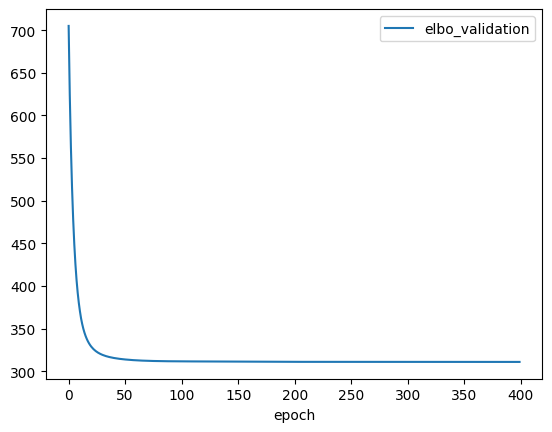

In [19]:
annot_model.history["elbo_validation"].plot()

In [27]:
predictions = annot_model.predict()
predictions.head()

,dg_d,dg_v,ca4,ca3_d,ca3_v,ca2,ca1_d,ca1_v
0,2.816668e-111,4.128243e-111,2.203562e-16,4.761632e-06,9.999952e-01,3.776062e-44,3.421942e-39,1.327904e-20
1,1.508438e-70,5.890581e-73,1.458533e-22,1.306772e-10,1.000000e+00,3.575331e-106,1.272547e-64,1.365609e-61
2,0.000000e+00,0.000000e+00,5.383473e-24,2.533097e-08,2.659833e-40,1.000000e+00,2.232102e-18,1.319631e-25
3,2.505314e-167,2.146975e-173,3.160725e-07,9.999892e-01,1.047385e-05,3.191836e-29,1.729080e-27,5.021047e-10
4,7.817662e-165,3.470935e-175,1.931415e-04,5.175501e-01,2.281776e-05,2.510498e-20,1.583865e-23,4.822340e-01


In [28]:
max_prob = predictions.max(axis=1)
predictions["cellassign_predictions"] = predictions.idxmax(axis=1).values
predictions['max_pp'] = max_prob

In [32]:
predictions.groupby(['cellassign_predictions'], observed=True).size()

cellassign_predictions
ca1_d      216
ca1_v     2189
ca2        315
ca3_d    10373
ca3_v    21264
ca4        709
dtype: int64

In [29]:
predictions['trust'] = "low"
predictions.loc[predictions.max_pp>=0.6,'trust'] = "barely"
predictions.loc[predictions.max_pp>=0.7,'trust'] = "mid"
predictions.loc[predictions.max_pp>=0.8,'trust'] = "high"
predictions.loc[predictions.max_pp>=0.9,'trust'] = "excellent"
predictions.loc[predictions.max_pp>=0.95,'trust'] = "completely"

In [43]:
predictions.groupby('trust', observed=True).size()

trust
barely          774
completely    29905
excellent      1194
high           1379
low             802
mid            1012
dtype: int64

In [26]:
adata_filt.obs.index.identical(adata_annot.obs.index)

True

In [38]:
adata_filt.obs["cellassign_predictions"] = predictions.cellassign_predictions.values
adata_filt.obs["trust"] = predictions.trust.values

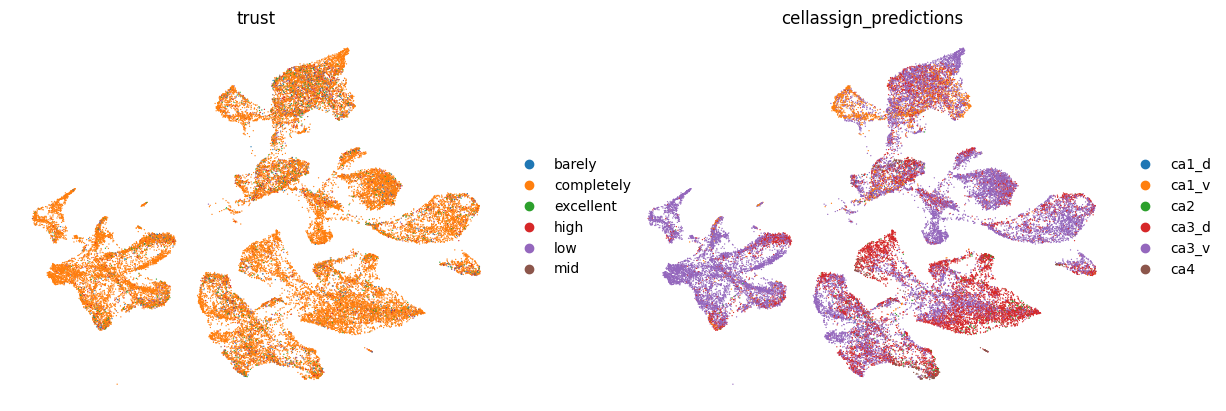

In [39]:
sc.pl.umap(adata_filt, color=["trust","cellassign_predictions"], frameon=False)

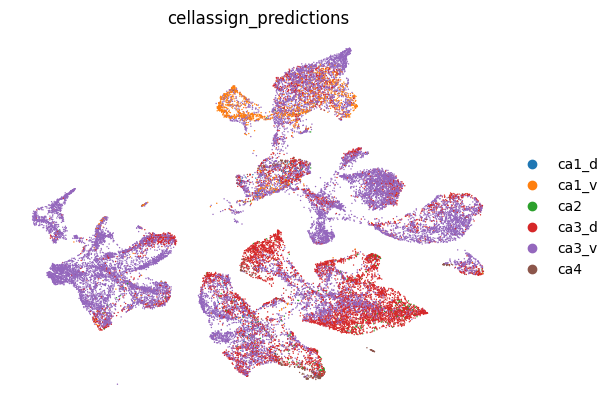

In [41]:
sc.pl.umap(adata_filt[adata_filt.obs.trust=="completely"], color="cellassign_predictions", frameon=False)